In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
data_path = Path("/home/user/data")
train_data_path = data_path / "ML" / "train"
test_data_path = data_path / "test"

In [3]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_data_path,
    labels="inferred",
    label_mode="binary",
    validation_split=0.2,
    subset="training",
    seed=0,
    image_size=image_size,
    batch_size=batch_size,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_data_path,
    labels="inferred",
    label_mode="binary",
    shuffle=False,
    seed=0,
    image_size=image_size,
    batch_size=batch_size,
)

Found 5000 files belonging to 2 classes.
Using 4000 files for training.


2021-11-09 17:19:56.514986: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 17:19:56.527952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 17:19:56.528902: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Found 6000 files belonging to 2 classes.


2021-11-09 17:19:56.531085: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-09 17:19:56.533115: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 17:19:56.533998: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 17:19:56.534925: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

2021-11-09 17:19:57.778723: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


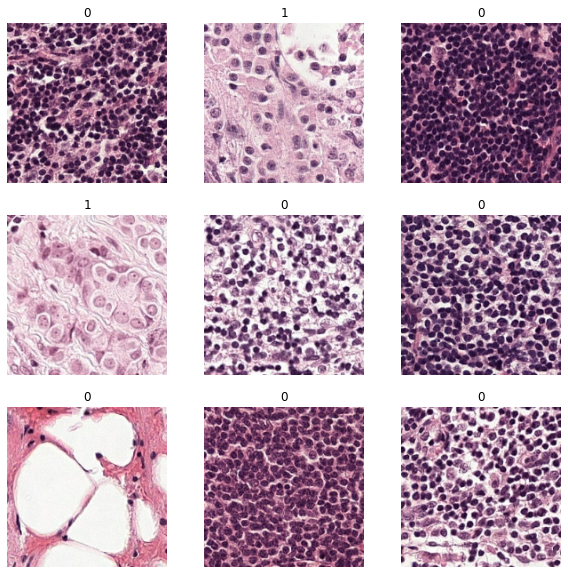

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [6]:
train_ds = train_ds.prefetch(buffer_size=batch_size)


In [7]:
base_model = tf.keras.applications.EfficientNetB3(
weights='imagenet',  # Load weights pre-trained on ImageNet.
input_shape=(180, 180, 3),
include_top=False)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False


43950080/43941136 [==============================] - 1s 0us/step


In [8]:
input_shape = image_size + (3,)
inputs = keras.Input(shape=input_shape)
# Image augmentation block
x = data_augmentation(inputs)

# Entry block
x = layers.Rescaling(1.0 / 255)(x)
    
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1,activation="sigmoid")(x)
model = keras.Model(inputs, outputs)


In [9]:
epochs = 10

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()],
)
model.fit(train_ds, epochs=epochs)

Epoch 1/10


2021-11-09 17:20:13.598725: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204


125/125 [==============================] - 17s 56ms/step - loss: 0.3576 - binary_accuracy: 0.8590 - auc: 0.8874
Epoch 2/10
125/125 [==============================] - 7s 56ms/step - loss: 0.2719 - binary_accuracy: 0.9030 - auc: 0.9240
Epoch 3/10
125/125 [==============================] - 7s 56ms/step - loss: 0.2527 - binary_accuracy: 0.9097 - auc: 0.9331
Epoch 4/10
125/125 [==============================] - 7s 56ms/step - loss: 0.2410 - binary_accuracy: 0.9118 - auc: 0.9390
Epoch 5/10
125/125 [==============================] - 7s 56ms/step - loss: 0.2319 - binary_accuracy: 0.9147 - auc: 0.9430
Epoch 6/10
125/125 [==============================] - 7s 56ms/step - loss: 0.2250 - binary_accuracy: 0.9178 - auc: 0.9470
Epoch 7/10
125/125 [==============================] - 7s 56ms/step - loss: 0.2185 - binary_accuracy: 0.9208 - auc: 0.9511
Epoch 8/10
125/125 [==============================] - 7s 56ms/step - loss: 0.2140 - binary_accuracy: 0.9195 - auc: 0.9528
Epoch 9/10
125/125 [==============

### Test

In [10]:
predictions = np.array([])
labels =  np.array([])
for x, y in test_ds:
    predictions = np.concatenate([predictions, model.predict(x).ravel()])
    labels = np.concatenate([labels, y.numpy().ravel()])

In [14]:
model.evaluate(test_ds)

188/188 [==============================] - 13s 55ms/step - loss: 0.2790 - binary_accuracy: 0.8958 - auc: 0.9435


[0.2790321111679077, 0.8958333134651184, 0.9435189962387085]

In [11]:
file_paths = test_ds.file_paths

In [12]:
df_submission = pd.DataFrame(data={'file_paths': file_paths, 'predictions': predictions})
df_submission["file_paths"] = df_submission["file_paths"].apply(lambda x: x.replace("/home/user/data/test","/data/challenges_data/test"))

In [13]:
df_submission.to_csv('df_submission.csv', index=False)
df_submission.head()

,file_paths,predictions
0,/data/challenges_data/test/target_0/normal_0_1...,0.109662
1,/data/challenges_data/test/target_0/normal_0_1...,0.019267
2,/data/challenges_data/test/target_0/normal_0_1...,0.185203
3,/data/challenges_data/test/target_0/normal_0_1...,0.069801
4,/data/challenges_data/test/target_0/normal_0_1...,0.149523
